### Physical constraints

Are the physical constraints satisfied in the dataset?

In [43]:
import gc
import os
import sys
import json
import time
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt 

from sklearn.linear_model import LinearRegression

# Try 500,1000,5000,10000
# subset_size = int(sys.argv[4])
subset_size = 1000

# 221108: Try eight input features
no_features = 5

**Load data**

In [44]:
all_possible_features = ['hus', 'clw', 'cli', 'ta', 'pa', 'zg', 'fr_land', 'U', 'rh', 'ps', 'hus_z', 'hus_zz', 'clw_z', 'clw_zz', 'cli_z',\
            'cli_zz', 'ta_z', 'ta_zz', 'pa_z', 'pa_zz', 'U_z', 'U_zz', 'rh_z', 'rh_zz']

loc = {}
for i in range(len(all_possible_features)):
    loc[all_possible_features[i]] = i
    
# Features
if no_features == 5:
    features = ['rh', 'ta', 'clw', 'cli', 'rh_z']
elif no_features == 8:
    features = ['rh', 'ta', 'clw', 'cli', 'rh_z', 'rh_zz', 'pa_z', 'pa_zz']

In [45]:
path_data = os.path.join('~/my_work/icon-ml_data/cloud_cover_parameterization/neighborhood_based_SR_DYAMOND')

# Load the input data and pick the five best features (rh, ta, clw, cli, rh_z)
input_data = np.load(path_data + '/cloud_cover_input_dyamond.npy')
input_data = np.concatenate([np.expand_dims(input_data[:, loc[sel_var]], axis=1) for sel_var in features], axis = 1)

output_data = np.load(path_data + '/cloud_area_output_dyamond.npy')

In [48]:
# Update loc
loc = {}
for i in range(len(features)):
    loc[features[i]] = i

In [5]:
(samples_total, no_of_features) = input_data.shape
(samples_total, no_of_features)

(285179494, 5)

In [6]:
def split_into_parts(input_data, feat, root_nparts):
    '''
        We have to split the samples into bins of similar values for the features.
        Actually we split the data into root_nparts**3 parts!
    '''
    parts = {}
    
    # inds w.r.t. which to NOT split the data
    # So if feat = 'clw', then inds will be the indices corresponding to 'rh', 'ta', 'cli'
    inds = np.delete(np.arange(4), loc[feat])
    
    mins = [np.min(input_data[:, ind]) for ind in inds]
    maxs = [np.max(input_data[:, ind]) for ind in inds]
    
    # Define thresholds for the parts
    thresholds = []
    for i in range(len(inds)):
        thresholds.append([mins[i] + (maxs[i] - mins[i])/root_nparts*k for k in range(root_nparts + 1)])
    thresholds = np.array(thresholds)
    
    # Split inefficiently
    for k in range(root_nparts):
        for l in range(root_nparts):
            for m in range(root_nparts):
                k_cond = np.logical_and(thresholds[0, k] <= input_data[:, inds[0]], input_data[:, inds[0]] < thresholds[0, k+1])
                l_cond = np.logical_and(thresholds[1, l] <= input_data[:, inds[1]], input_data[:, inds[1]] < thresholds[1, l+1])
                m_cond = np.logical_and(thresholds[2, m] <= input_data[:, inds[2]], input_data[:, inds[2]] < thresholds[2, m+1])
                parts['part_%d_%d_%d'%(k,l,m)] = np.logical_and(np.logical_and(k_cond, l_cond), m_cond)
    
    return parts

In [69]:
no_boxes = {}

**With root_nparts = 1**

In [16]:
features = ['rh', 'ta', 'clw', 'cli', 'rh_z']
reg = LinearRegression().fit(input_data, output_data)
reg.coef_

array([ 1.07877389e+02, -4.35510412e-01,  1.22958557e+05,  7.94257603e+05,
       -8.30559550e+03])

In [71]:
no_boxes[1] = [1,1,1,1]

**With root_nparts = 2**

In [17]:
feats = ['rh', 'clw', 'cli', 'ta']

for feat in feats:
    data_parts = split_into_parts(input_data, feat, 2)

    slope = []
    for i, key in enumerate(data_parts.keys()):    
        if np.sum(data_parts[key]) > 10**4:
            reg = LinearRegression().fit(input_data[data_parts[key], loc[feat]].reshape(-1, 1), output_data[data_parts[key]])
            slope.append(reg.coef_)

    print(feat)
    print(slope)
    cond_check = np.sum(np.array([np.sign(slope[i][0]) for i in range(len(slope))]) >= 0)/len(slope)*100
    print('The slope is positive in %d percent of the boxes.'%cond_check)

rh
[array([132.62618812]), array([109.11668485])]
The slope is positive in 100 percent of the boxes.
clw
[array([2563736.09709541]), array([396716.23250383]), array([26406.65794995])]
The slope is positive in 100 percent of the boxes.
cli
[array([1547820.89083941]), array([2092000.36446131]), array([192180.65852284])]
The slope is positive in 100 percent of the boxes.
ta
[array([0.2535633]), array([-0.24201958])]
The slope is positive in 50 percent of the boxes.


In [72]:
no_boxes[2] = [2,3,3,2]

**With root_nparts = 3**

In [22]:
feats = ['rh', 'clw', 'cli', 'ta']

for feat in feats:
    data_parts = split_into_parts(input_data, feat, 3)

    slope = []
    for i, key in enumerate(data_parts.keys()):    
        if np.sum(data_parts[key]) > 10**4:
            reg = LinearRegression().fit(input_data[data_parts[key], loc[feat]].reshape(-1, 1), output_data[data_parts[key]])
            slope.append(reg.coef_)

    print(feat)
    print(slope)
    cond_check = np.sum(np.array([np.sign(slope[i][0]) for i in range(len(slope))]) >= 0)/len(slope)*100
    print('The slope is positive in %d percent of the boxes.'%cond_check)

rh
[array([131.31105334]), array([114.47521447]), array([115.88481455]), array([15.28992936])]
The slope is positive in 100 percent of the boxes.
clw
[array([8.2812577e+09]), array([800828.11522331]), array([511281.79759947]), array([-39628654.82774796]), array([103975.60081398]), array([207812.11684276])]
The slope is positive in 83 percent of the boxes.
cli
[array([1396348.59458826]), array([2154644.36480149]), array([25393686.1380742]), array([232378.01692896]), array([544603.85421473]), array([2358011.66940793]), array([-68261.983664])]
The slope is positive in 85 percent of the boxes.
ta
[array([-0.20000514]), array([-0.62784529]), array([-0.00833442])]
The slope is positive in 0 percent of the boxes.


In [73]:
no_boxes[3] = [4,6,7,3]

**With root_nparts = 4**

In [23]:
feats = ['rh', 'clw', 'cli', 'ta']

for feat in feats:
    data_parts = split_into_parts(input_data, feat, 4)

    slope = []
    for i, key in enumerate(data_parts.keys()):    
        if np.sum(data_parts[key]) > 10**4:
            reg = LinearRegression().fit(input_data[data_parts[key], loc[feat]].reshape(-1, 1), output_data[data_parts[key]])
            slope.append(reg.coef_)

    print(feat)
    print(slope)
    cond_check = np.sum(np.array([np.sign(slope[i][0]) for i in range(len(slope))]) >= 0)/len(slope)*100
    print('The slope is positive in %d percent of the boxes.'%cond_check)

rh
[array([114.63558309]), array([132.64217213]), array([74.73201065]), array([112.02779825]), array([34.37866703]), array([126.98739487]), array([22.62710006])]
The slope is positive in 100 percent of the boxes.
clw
[array([1.13344935e+10]), array([1558162.10051125]), array([719851.61702111]), array([535048.66586404]), array([2.1192347e+09]), array([-283257.38132629]), array([16460.79186508]), array([177901.42190844]), array([456303.98775238]), array([19823.20084268]), array([42804.10718712])]
The slope is positive in 90 percent of the boxes.
cli
[array([1626919.97333788]), array([1738210.63393382]), array([5504987.28001411]), array([-1075867.37957506]), array([336331.54140396]), array([475217.40621034]), array([1439734.82491045]), array([-1455180.11179077]), array([-20907655.26595008]), array([-4.66230639e+09]), array([149379.84612343]), array([-51994.00224814]), array([-44441807.30470899]), array([-3.31797208e+09])]
The slope is positive in 50 percent of the boxes.
ta
[array([-0.027

In [74]:
no_boxes[4] = [7,11,14,6]

**With root_nparts = 5**

In [7]:
feats = ['rh', 'clw', 'cli', 'ta']

for feat in feats:
    data_parts = split_into_parts(input_data, feat, 5)

    slope = []
    for i, key in enumerate(data_parts.keys()):    
        if np.sum(data_parts[key]) > 10**4:
            reg = LinearRegression().fit(input_data[data_parts[key], loc[feat]].reshape(-1, 1), output_data[data_parts[key]])
            slope.append(reg.coef_)

    print(feat)
    print(slope)
    cond_check = np.sum(np.array([np.sign(slope[i][0]) for i in range(len(slope))]) >= 0)/len(slope)*100
    print('The slope is positive in %d percent of the boxes.'%cond_check)

rh
[array([101.13153635]), array([137.08265693]), array([133.22038293]), array([130.44044232]), array([12.74460267]), array([113.49787759]), array([42.94893701]), array([10.22364678]), array([123.80363171]), array([62.33500172])]
The slope is positive in 100 percent of the boxes.
clw
[array([2.10907119e+10]), array([13983711.78884216]), array([1089457.71909217]), array([705999.48852718]), array([821453.37739304]), array([1.35712925e+10]), array([2125457.54918279]), array([-354792.3412919]), array([-53789.30519759]), array([496038.43777316]), array([808130.12835793]), array([-5671.96211642]), array([-56731.58747488]), array([121358.4573963]), array([547181.7167984])]
The slope is positive in 73 percent of the boxes.
cli
[array([2777406.05489965]), array([1961366.9772224]), array([3277391.13253667]), array([18921094.23177182]), array([-381099.51009338]), array([836136.7180044]), array([507168.57812466]), array([1179955.28459967]), array([6723582.27038417]), array([-2585210.29627586]), ar

In [75]:
no_boxes[5] = [10,15,16,7]

**With root_nparts = 6**

In [8]:
feats = ['rh', 'clw', 'cli', 'ta']

for feat in feats:
    data_parts = split_into_parts(input_data, feat, 6)

    slope = []
    for i, key in enumerate(data_parts.keys()):    
        if np.sum(data_parts[key]) > 10**4:
            reg = LinearRegression().fit(input_data[data_parts[key], loc[feat]].reshape(-1, 1), output_data[data_parts[key]])
            slope.append(reg.coef_)

    print(feat)
    print(slope)
    cond_check = np.sum(np.array([np.sign(slope[i][0]) for i in range(len(slope))]) >= 0)/len(slope)*100
    print('The slope is positive in %d percent of the boxes.'%cond_check)

rh
[array([86.28808323]), array([136.31314384]), array([183.80615386]), array([137.98854326]), array([90.38860043]), array([116.17204702]), array([27.93875349]), array([35.89628145]), array([117.50270767]), array([52.85766175]), array([15.61361588]), array([70.95556737])]
The slope is positive in 100 percent of the boxes.
clw
[array([2.3160323e+10]), array([5.01425376e+09]), array([1156539.97866582]), array([1008480.43948086]), array([681365.37939976]), array([588834.02765456]), array([2.63390261e+10]), array([2.33875983e+09]), array([-7.33452546e+08]), array([143787.36070304]), array([924602.21441198]), array([494502.0436566]), array([1344729.58982811]), array([-93461384.11402944]), array([-391590.38080436]), array([-165839.95587909]), array([91560.70905048]), array([-57249.82031552]), array([287659.9204117]), array([2224500.63754626]), array([21235.03446042]), array([30636.79834285]), array([335599.65191493])]
The slope is positive in 78 percent of the boxes.
cli
[array([6237235.7726

In [79]:
no_boxes[6] = [12,23,24,9]

**With root_nparts = 7**

In [9]:
feats = ['rh', 'clw', 'cli', 'ta']

for feat in feats:
    data_parts = split_into_parts(input_data, feat, 7)

    slope = []
    for i, key in enumerate(data_parts.keys()):    
        if np.sum(data_parts[key]) > 10**4:
            reg = LinearRegression().fit(input_data[data_parts[key], loc[feat]].reshape(-1, 1), output_data[data_parts[key]])
            slope.append(reg.coef_)

    print(feat)
    print(slope)
    cond_check = np.sum(np.array([np.sign(slope[i][0]) for i in range(len(slope))]) >= 0)/len(slope)*100
    print('The slope is positive in %d percent of the boxes.'%cond_check)

rh
[array([56.7918629]), array([128.72639903]), array([235.46863821]), array([138.11247762]), array([137.91352006]), array([134.86350544]), array([28.1160334]), array([111.19198511]), array([68.27987444]), array([65.09380307]), array([28.12788068]), array([121.29934633]), array([57.57964825]), array([21.82596594]), array([7.93819771]), array([1.6783006])]
The slope is positive in 100 percent of the boxes.
clw
[array([2.26854793e+10]), array([8.51004066e+09]), array([4359034.78576699]), array([816332.38561515]), array([807979.60126845]), array([682996.63950631]), array([93706.84668063]), array([4.72535171e+10]), array([6.49187539e+09]), array([-1.02964398e+09]), array([5573568.88279146]), array([-940880.08472876]), array([1091534.29409341]), array([769792.71508854]), array([494033.21963999]), array([1157388.86884833]), array([1.06987805e+10]), array([46442612.97758944]), array([-4.92641943e+08]), array([-1412335.04186535]), array([-1005837.65999334]), array([-289016.31314256]), array([-

In [81]:
no_boxes[7] = [16,32,32,12]

In [21]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

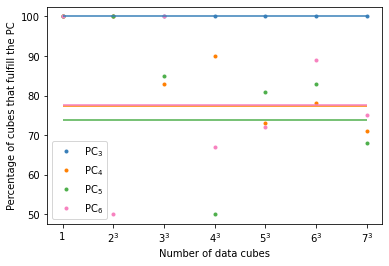

In [93]:
pc3 = 100*np.ones(7)
pc4 = [100,100,83,90,73,78,71]
pc5 = [100,100,85,50,81,83,68]
pc6 = [100,50,100,67,72,89,75]

plt.plot(['1','$2^3$','$3^3$','$4^3$','$5^3$','$6^3$','$7^3$'], pc3, '.', color=CB_color_cycle[0])
plt.plot(['1','$2^3$','$3^3$','$4^3$','$5^3$','$6^3$','$7^3$'], pc4, '.', color=CB_color_cycle[1])
plt.plot(['1','$2^3$','$3^3$','$4^3$','$5^3$','$6^3$','$7^3$'], pc5, '.', color=CB_color_cycle[2])
plt.plot(['1','$2^3$','$3^3$','$4^3$','$5^3$','$6^3$','$7^3$'], pc6, '.', color=CB_color_cycle[3])

mean_pc3 = np.sum([pc3[i]*np.array(no_boxes[i+1][0]) for i in range(7)])/np.sum([np.array(no_boxes[i][0]) for i in range(1, 8)])
mean_pc4 = np.sum([pc4[i]*np.array(no_boxes[i+1][1]) for i in range(7)])/np.sum([np.array(no_boxes[i][1]) for i in range(1, 8)])
mean_pc5 = np.sum([pc5[i]*np.array(no_boxes[i+1][2]) for i in range(7)])/np.sum([np.array(no_boxes[i][2]) for i in range(1, 8)])
mean_pc6 = np.sum([pc6[i]*np.array(no_boxes[i+1][3]) for i in range(7)])/np.sum([np.array(no_boxes[i][3]) for i in range(1, 8)])

plt.hlines(mean_pc3, 0, 6, color=CB_color_cycle[0])
plt.hlines(mean_pc4, 0, 6, color=CB_color_cycle[1])
plt.hlines(mean_pc5, 0, 6, color=CB_color_cycle[2])
plt.hlines(mean_pc6, 0, 6, color=CB_color_cycle[3])

plt.legend(['PC$_3$', 'PC$_4$', 'PC$_5$', 'PC$_6$'])
plt.ylabel('Percentage of cubes that fulfill the PC')
plt.xlabel('Number of data cubes')
plt.savefig('physical_constraints/in_data.pdf')

In [ ]:
# print(mean_pc3) - 100.0
# print(mean_pc4) - 77.46
# print(mean_pc5) - 73.80
# print(mean_pc6) - 77.68

**PC2**

In [66]:
for epsilon in [1e-10, 1e-20, 1e-30, 1e-40]:
    cond_free_output = output_data[input_data[:, loc['clw']] + input_data[:, loc['cli']] < epsilon]
    print(np.sum(cond_free_output < epsilon)/len(cond_free_output))

0.9954588109560885
0.9972440237020315
0.9972440235608266
0.9972440235608266
